<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/1_GPax_GP_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process-based Bayesian optimization

- Prepared by Maxim Ziatdinov (2022), adapted by SVK
- Several examples are based on ChatGPT

# Kernels

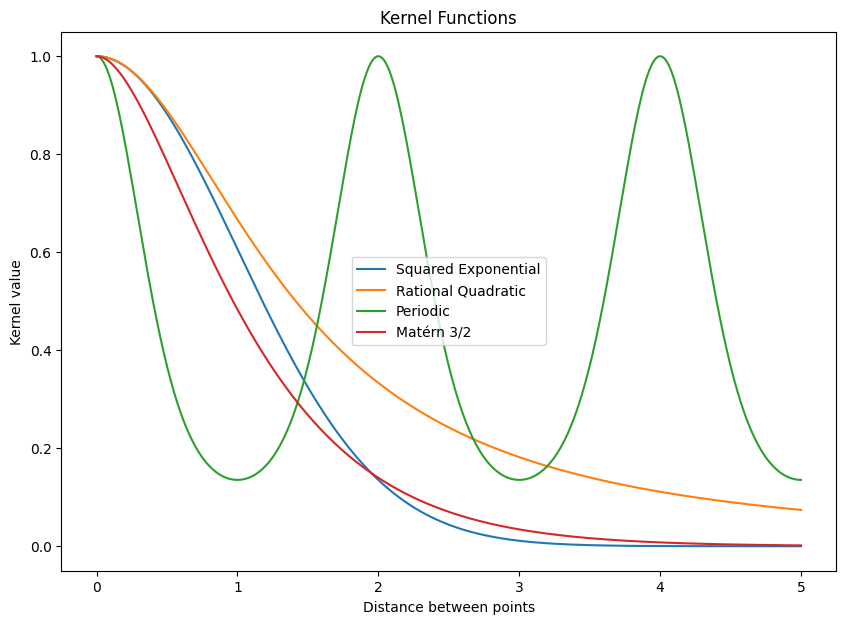

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the kernels
def squared_exponential_kernel(d, length_scale=1.0, variance=1.0):
    """Squared Exponential Kernel"""
    return variance * np.exp(-0.5 / length_scale**2 * d**2)

def rational_quadratic_kernel(d, length_scale=1.0, alpha=1.0, variance=1.0):
    """Rational Quadratic Kernel"""
    return variance * (1 + d**2 / (2 * alpha * length_scale**2))**(-alpha)

def periodic_kernel(d, length_scale=1.0, period=2.0, variance=1.0):
    """Periodic Kernel"""
    return variance * np.exp(-2 * np.sin(np.pi * d / period)**2 / length_scale**2)

def matern_kernel(d, length_scale=1.0, nu=1.5, variance=1.0):
    """Matérn Kernel with nu=3/2"""
    sqrt3 = np.sqrt(3)
    return variance * (1 + sqrt3 * d / length_scale) * np.exp(-sqrt3 * d / length_scale)

# Generate distances
d = np.linspace(0, 5, 400)

# Compute kernel values
K_SE = squared_exponential_kernel(d)
K_RQ = rational_quadratic_kernel(d)
K_P = periodic_kernel(d)
K_M = matern_kernel(d)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(d, K_SE, label='Squared Exponential')
plt.plot(d, K_RQ, label='Rational Quadratic')
plt.plot(d, K_P, label='Periodic')
plt.plot(d, K_M, label='Matérn 3/2')
plt.title('Kernel Functions')
plt.xlabel('Distance between points')
plt.ylabel('Kernel value')
plt.legend()
plt.show()


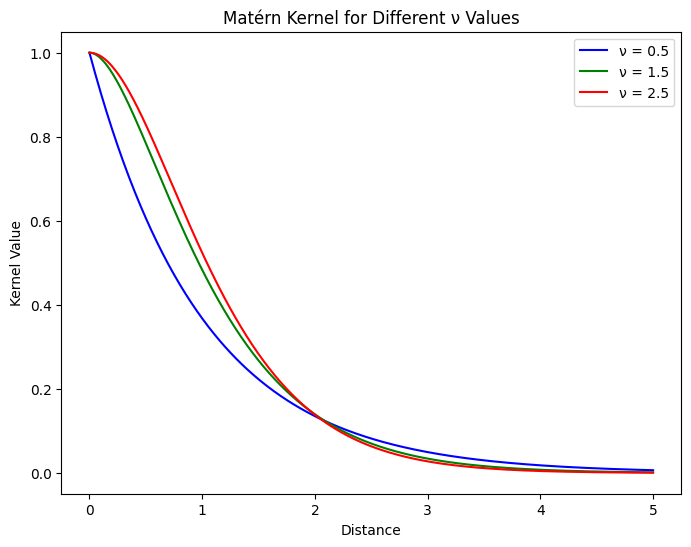

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma

def matern_kernel(distance, length_scale=1.0, nu=1.5, variance=1.0):
    """Matérn kernel as a function of distance."""
    if distance == 0:
        return variance
    else:
        sqrt_2_nu_distance = np.sqrt(2 * nu) * distance / length_scale
        scale = variance * (2 ** (1 - nu)) / gamma(nu)
        return scale * (sqrt_2_nu_distance ** nu) * kv(nu, sqrt_2_nu_distance)

# Generate a range of distances from 0 to 5
distances = np.linspace(0, 5, 500)

# Settings for different ν values
nus = [0.5, 1.5, 2.5]
colors = ['blue', 'green', 'red']
labels = [f'ν = {nu}' for nu in nus]

plt.figure(figsize=(8, 6))

for nu, color, label in zip(nus, colors, labels):
    # Calculate kernel values across distances for a given ν
    kernel_values = [matern_kernel(d, nu=nu) for d in distances]
    plt.plot(distances, kernel_values, label=label, color=color)

plt.title('Matérn Kernel for Different ν Values')
plt.xlabel('Distance')
plt.ylabel('Kernel Value')
plt.legend()
plt.show()


# GPs for different kernels

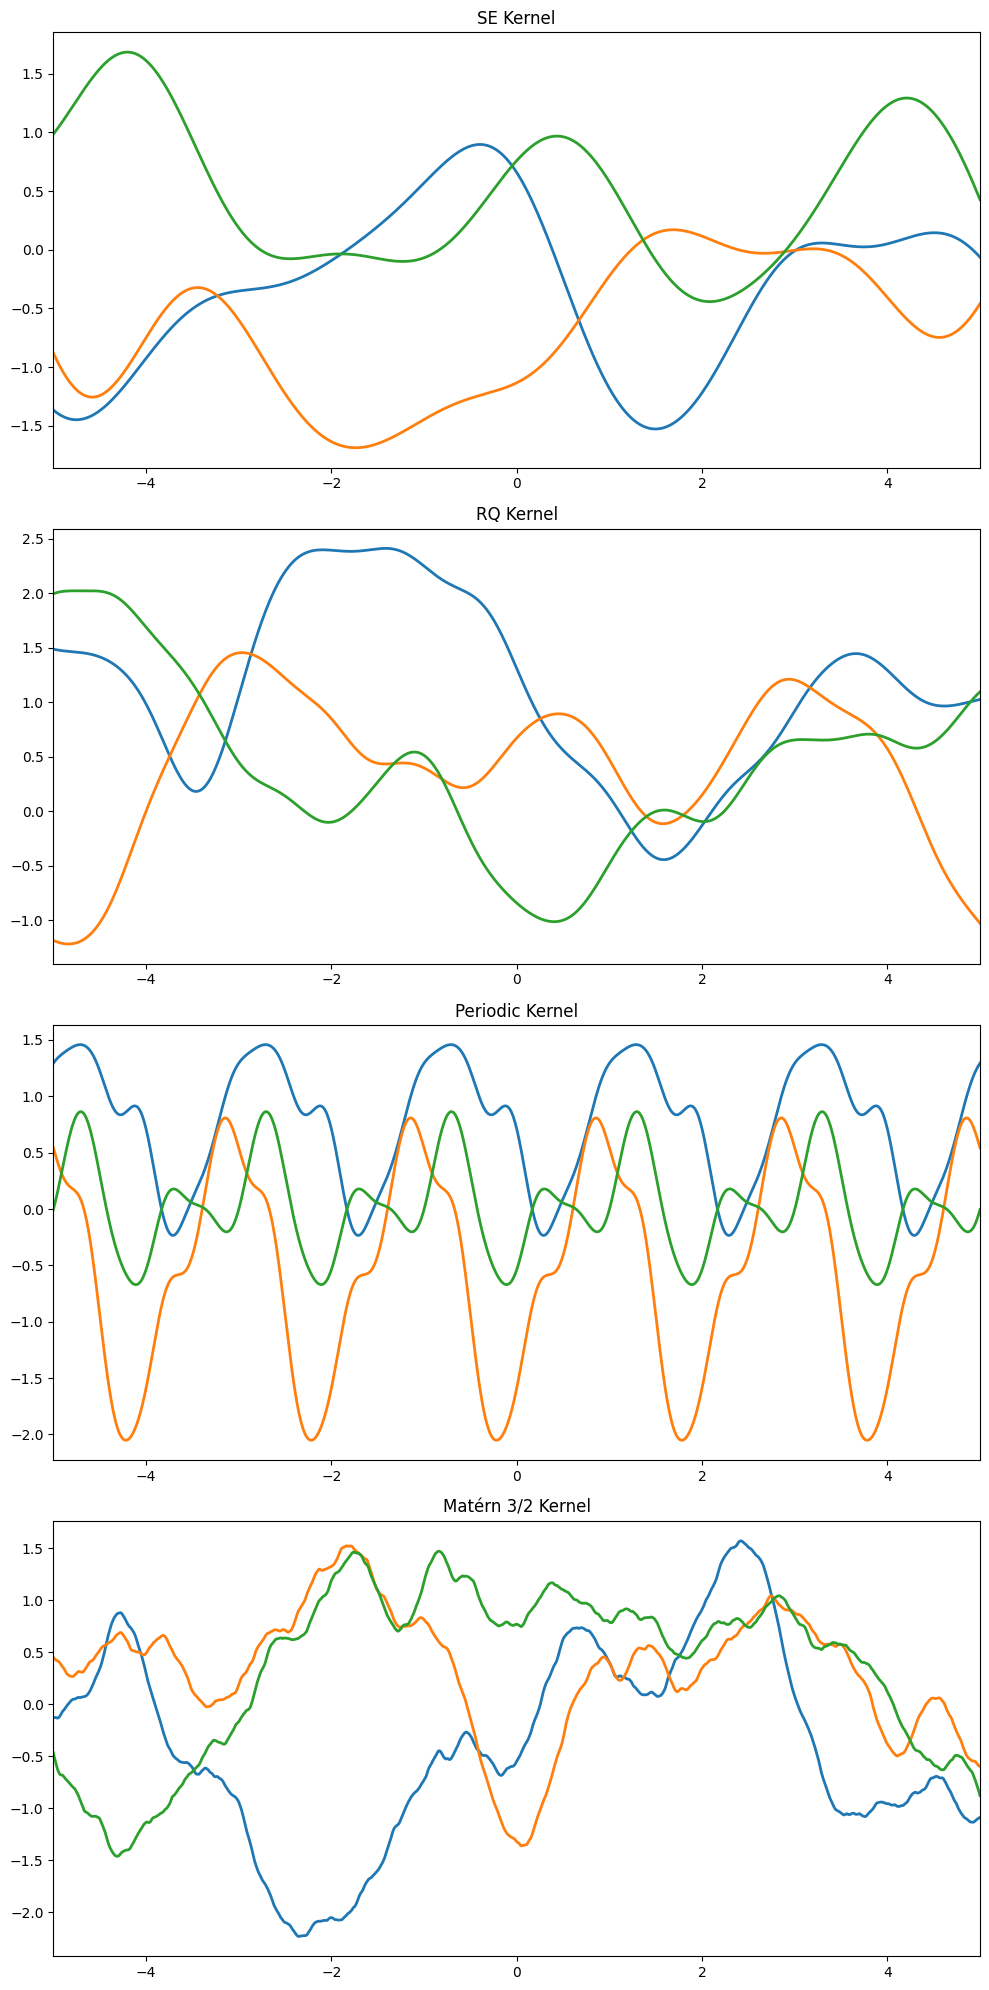

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the kernels
def squared_exponential_kernel(x, y, length_scale=1.0, variance=1.0):
    """Squared Exponential Kernel"""
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

def rational_quadratic_kernel(x, y, length_scale=1.0, alpha=1.0, variance=1.0):
    """Rational Quadratic Kernel"""
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return variance * (1 + sqdist / (2 * alpha * length_scale**2))**(-alpha)

def periodic_kernel(x, y, length_scale=1.0, period=2.0, variance=1.0):
    """Periodic Kernel"""
    sqdist = np.pi * (x - y.T) / period
    return variance * np.exp(-2 * (np.sin(sqdist) / length_scale)**2)

def matern_kernel(x, y, length_scale=1.0, nu=0.5, variance=1.0):
    """Matérn Kernel with nu=3/2"""
    sqrt3 = np.sqrt(3)
    sqdist = np.sqrt(np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T))
    return variance * (1 + sqrt3 * sqdist / length_scale) * np.exp(-sqrt3 * sqdist / length_scale)

# Generate data
X = np.linspace(-5, 5, 1000).reshape(-1, 1)

# Compute kernel matrices
K_SE = squared_exponential_kernel(X, X)
K_RQ = rational_quadratic_kernel(X, X)
K_P = periodic_kernel(X, X)
K_M = matern_kernel(X, X)  # Matérn kernel

# Drawing samples from the GP prior
np.random.seed(42)  # For reproducibility
samples_SE = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_SE, size=3)
samples_RQ = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_RQ, size=3)
samples_P = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_P, size=3)
samples_M = np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K_M, size=3)  # Samples for Matérn kernel

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  # Adjusted for an additional row

for ax, samples, title in zip(axs, [samples_SE, samples_RQ, samples_P, samples_M], ['SE Kernel', 'RQ Kernel', 'Periodic Kernel', 'Matérn 3/2 Kernel']):
    for i in range(samples.shape[0]):
        ax.plot(X, samples[i], lw=2)
    ax.set_title(title)
    ax.set_xlim([-5, 5])

plt.tight_layout()
plt.show()


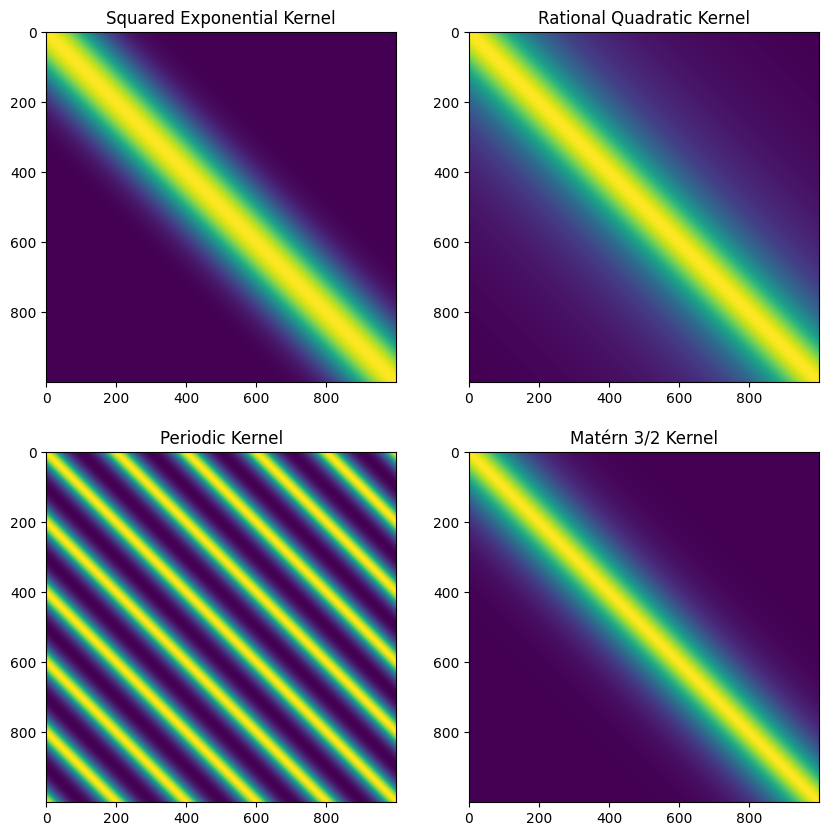

In [18]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each kernel matrix as an imshow
axs[0, 0].imshow(K_SE)
axs[0, 0].set_title('Squared Exponential Kernel')
axs[0, 1].imshow(K_RQ)
axs[0, 1].set_title('Rational Quadratic Kernel')
axs[1, 0].imshow(K_P)
axs[1, 0].set_title('Periodic Kernel')
axs[1, 1].imshow(K_M)
axs[1, 1].set_title('Matérn 3/2 Kernel')

# Show the plot
plt.show()


# Instal GPax

In [19]:
!pip install gpax #git+https://github.com/ziatdinovmax/gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 12.9 MB/s eta 0:00:00


In [20]:
!pip install numpyro==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: numpyro
    Found existing installation: numpyro 0.14.0
    Uninstalling numpyro-0.14.0:
      Successfully uninstalled numpyro-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gpax 0.1.8 requires numpyro>=0.11.0, but you have numpyro 0.10.0 which is incompatible.


Imports:

In [21]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

import numpyro

gpax.utils.enable_x64()

# Define a data generation process (ground truth)

Let's define a function to be minimized and a function that emulates a noisy measurement:

SVK Note: Here, the function is ground truth. This is how nature behaves, but we do not know it. Purpose of the experiment is either learn this function (EU aquisition function), or discover minimum of this function (UCB aquisition function). Note that parameter beta in UCB determines balance between the explorationa and exploitation (if we set beta to zero, we make algorithm greedy so it get trapped into whatever minimum it discovers first). Also note that the noise that we add is a measurement noise that we define a priori. Experimentalist does not know what it is - you actually aim to learn it from the experiment.

In [22]:
def func(x, y=1.2):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e + 20
    )
    return out

def measure(x, noise= 0.01):
    return func(x) + noise * np.random.randn(len(x))

Next, we generate a few noisy observations of our function. We also plot the true function ("ground truth") to confirm the location of the minimum at $x=0$ but we are not going to use it anywhere.

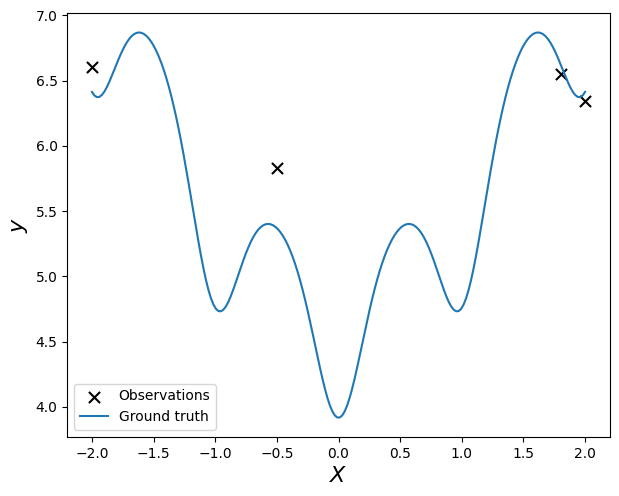

In [23]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(2,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X, noise = 0.3)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

# Define Gaussian Process Priors

The Gaussian process class in GPax uses a weakly informative $LogNormal(0,1)$ prior distribution for all kernel parameters and model noise by default. If we have prior knowledge that the noise level is low, we may choose a more appropriate prior distibution for the noise, such as

SVK note: Here, priors on noise and kernel length and scale are our best guesses before the experiment on how the measurement system behaves. Noise is combined effect of how precise are our measurements and how significant are other (uncontrollable) factors that affect the measurements. Kernel lengthscale is basically how rapidly we think the properties can change. Scale is simplest - it is just vertical scale. These guesses are very important - for example, if we think that our measurements are very precise (noise is small) but in reality noise is high, then algorithm will interpret each noise peak as as peak in ground truth (and can go horribly wrong by making kernel length very small). At the same time, if we set kernel length too large, it can never find small modulations in the function. Experiment with these paprameters! Noise in the ground truth vs. noise in the prior, and too big/too small kernel lengths.

In [24]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.010))

In [25]:
def gp_kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.10, 0.5)) #0.1 2
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    # the hyperparameters are returned as dictionary
    return {"k_length": length, "k_scale": scale}

It is a good idea to see what these distirbutions mean: HalfNormal, Uniform, LogNormal, Gamma, .... . You can use the following code snippet to visualize them:

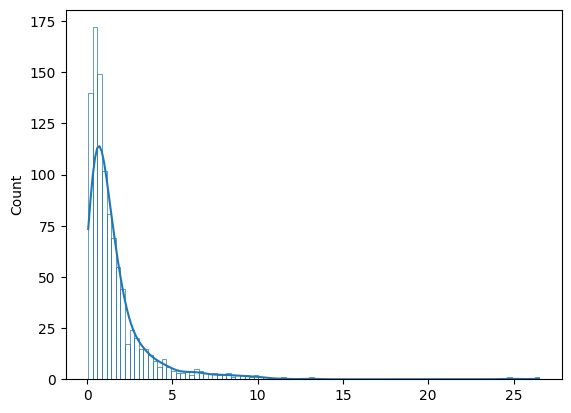

In [26]:
d = numpyro.distributions.LogNormal(0, 1)
gpax.utils.dviz(d, samples=1000)

Next we define a single step that takes measured data, trains a GP model, and uses it to compute an Upper Confidence Bound (UCB) acquisition function for deriving the next measurment point (which will be done inside the main loop).

In [27]:
def step(X_measured, y_measured, X_unmeasured):
    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()
    # Initialize GP model
    gp_model = gpax.ExactGP(1, kernel='RBF', kernel_prior=gp_kernel_prior, noise_prior=noise_prior)
    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(rng_key1, X_measured, y_measured)
    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True, n= 10)

    # Compute acquisition function
    # Upper confidence bound
    # obj = gpax.acquisition.UCB(
    #     rng_key2, gp_model, X_unmeasured, beta=0.01, #4
    #     maximize=False, noiseless=True)

    # pure uncertainty-based
    obj = gpax.acquisition.UE(
        rng_key2, gp_model, X_unmeasured,
        noiseless=True)


    return obj, (y_pred, y_sampled)

Finally, we run the Bayesian optimization for 7 steps to find the minimum of the unknown (to the algorithm) function:


Step 1/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:18<00:00, 217.57it/s, 7 steps of size 4.88e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.35      0.10      0.37      0.20      0.50   1675.98      1.00
   k_scale     15.99      8.16     14.17      6.00     26.62   1006.11      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1420.13      1.00



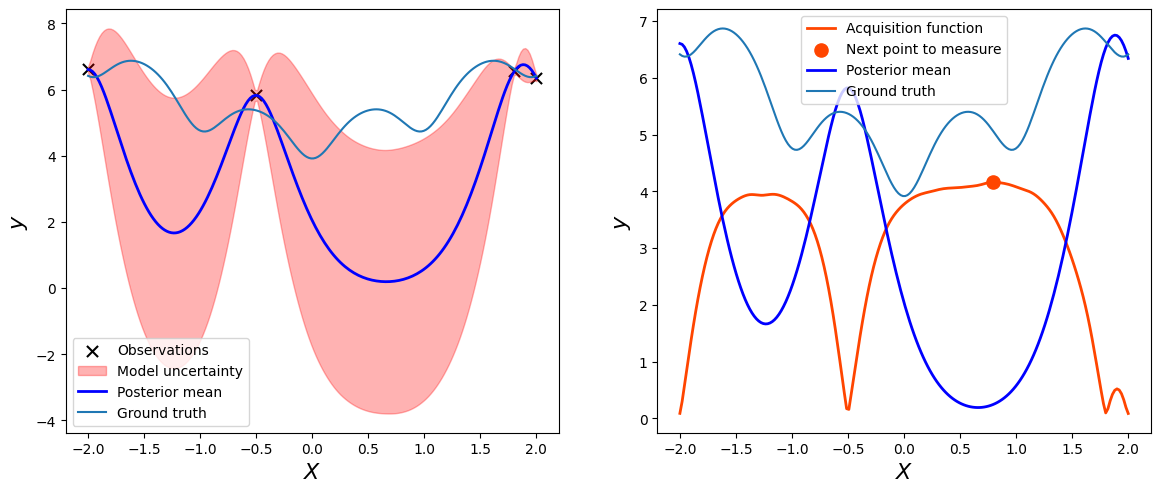


Step 2/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 783.95it/s, 7 steps of size 5.11e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.36      0.10      0.38      0.21      0.50   1723.83      1.00
   k_scale     16.54      7.56     14.89      6.57     26.88   1015.73      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1256.80      1.00



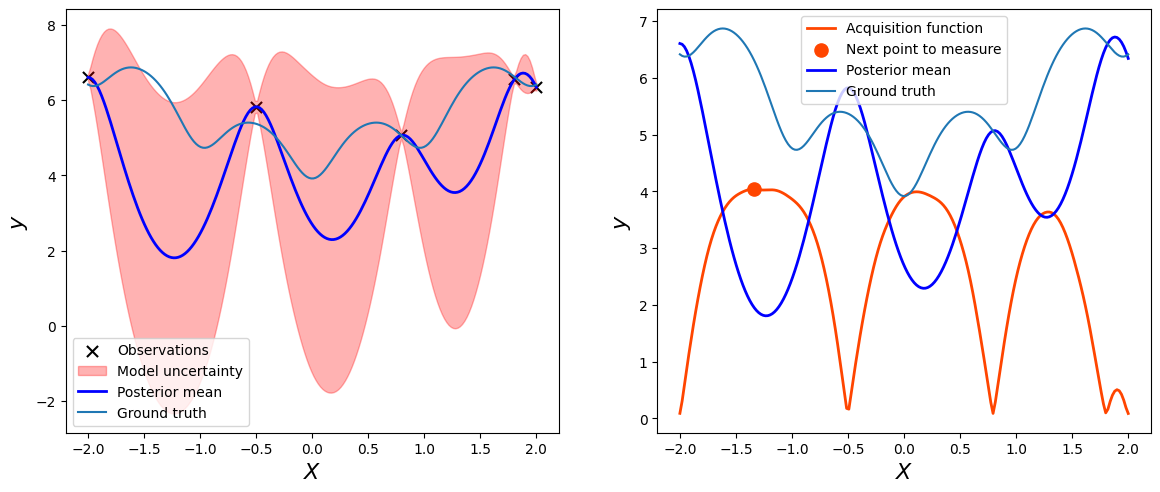


Step 3/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 678.57it/s, 7 steps of size 5.16e-01. acc. prob=0.90]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.40      0.09      0.43      0.27      0.50   1434.06      1.00
   k_scale     16.20      7.20     14.75      6.67     25.86   1064.43      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1314.80      1.00



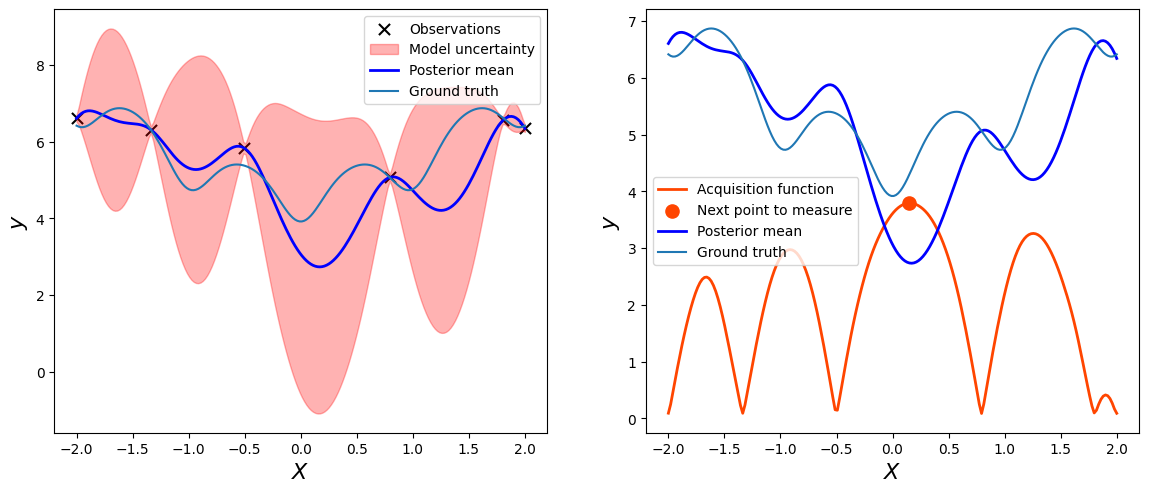


Step 4/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 776.09it/s, 7 steps of size 5.12e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.43      0.07      0.45      0.32      0.50   1254.84      1.00
   k_scale     15.00      6.95     13.43      6.09     24.54    916.42      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1444.60      1.00



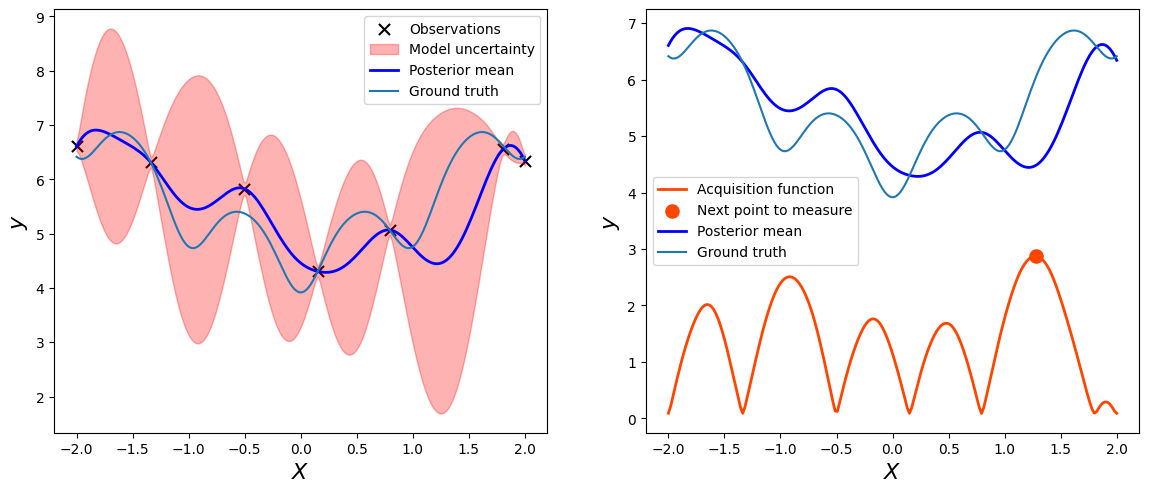


Step 5/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 786.39it/s, 15 steps of size 4.79e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.45      0.05      0.47      0.38      0.50   1303.19      1.00
   k_scale     13.90      5.86     12.65      5.94     21.77    961.75      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1562.85      1.00



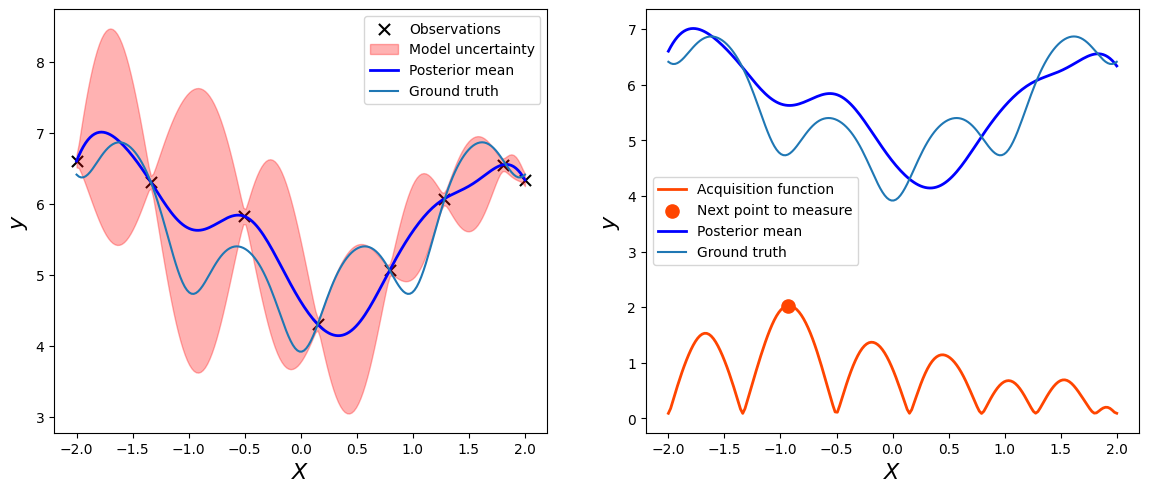


Step 6/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 668.65it/s, 7 steps of size 5.02e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.46      0.04      0.47      0.40      0.50   1605.14      1.00
   k_scale     13.06      5.25     11.98      5.69     19.98   1140.51      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1355.96      1.00



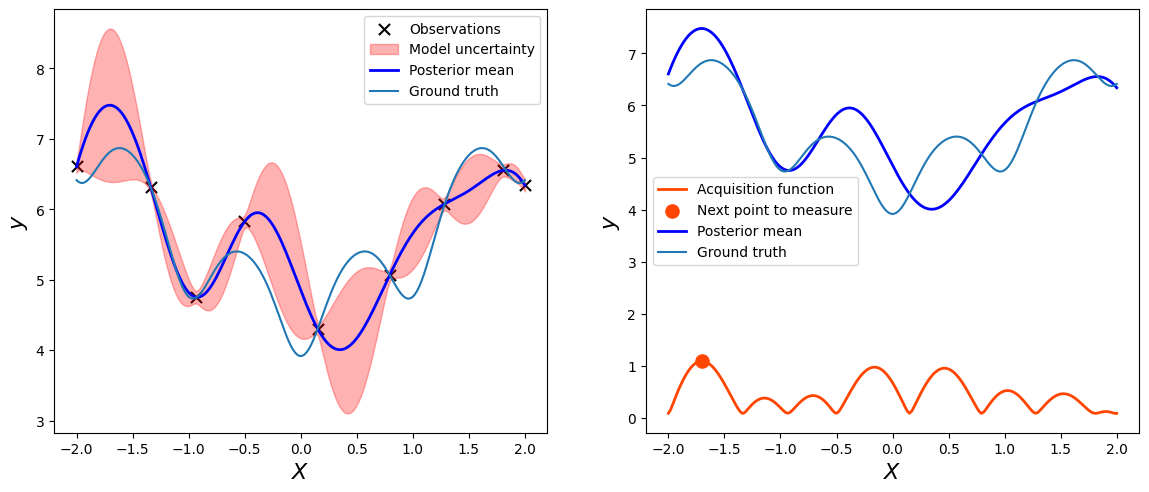


Step 7/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 766.89it/s, 7 steps of size 5.18e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.46      0.04      0.47      0.41      0.50   1594.00      1.00
   k_scale     12.58      5.02     11.48      6.23     19.41    983.27      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1136.75      1.00



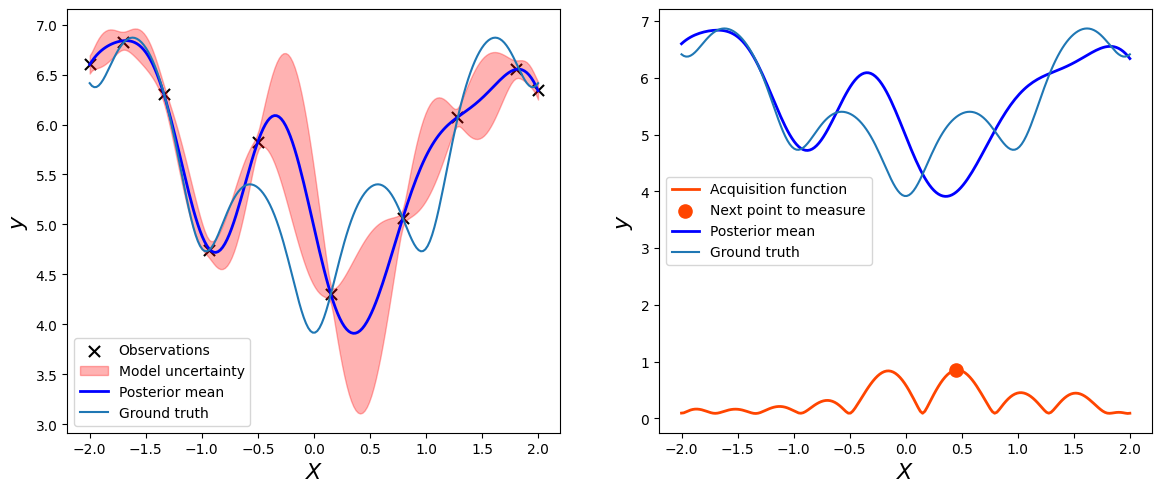


Step 8/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 611.25it/s, 7 steps of size 5.28e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.44      0.04      0.45      0.39      0.50   1652.41      1.00
   k_scale     13.90      5.39     12.77      7.10     21.50   1045.21      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1326.41      1.00



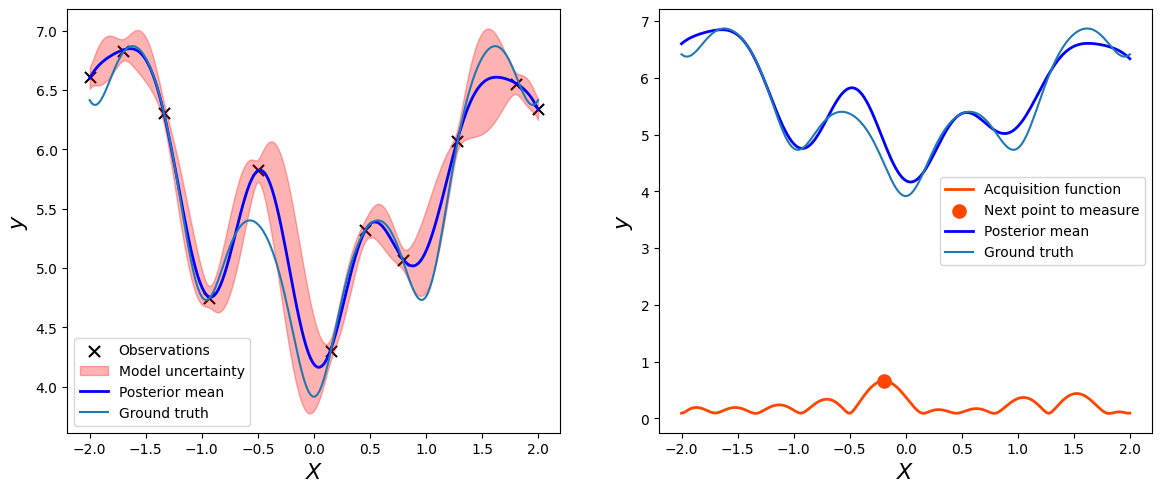


Step 9/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 720.36it/s, 7 steps of size 4.38e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.45      0.03      0.45      0.40      0.50   1503.39      1.00
   k_scale     13.98      5.32     12.92      6.94     21.38   1192.60      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1545.08      1.00



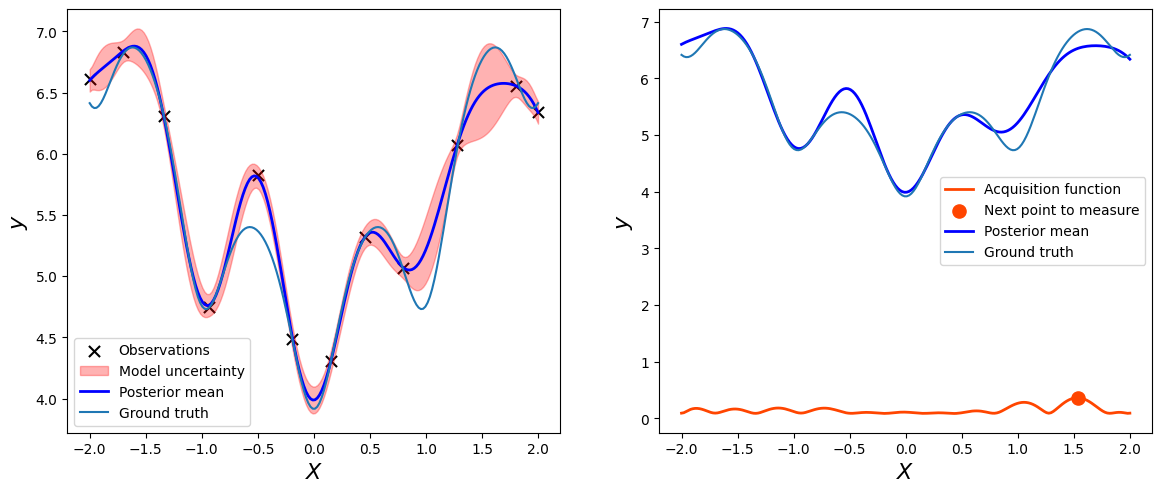


Step 10/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 619.55it/s, 7 steps of size 4.78e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.46      0.03      0.46      0.41      0.50   1526.70      1.00
   k_scale     13.69      5.03     12.69      6.30     20.19   1049.19      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1170.88      1.00



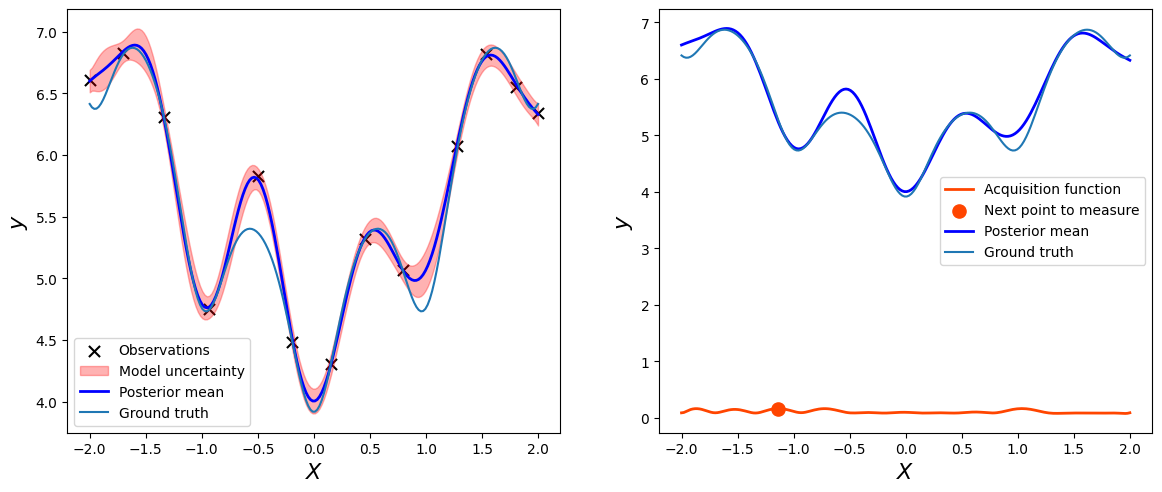

In [28]:
num_steps = 10

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured[idx:idx+1]
    # Measure the point
    next_point_value = measure(next_point)
    # Update measured data
    X = np.append(X, X_unmeasured[idx:idx+1])
    y = np.append(y, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
        ax.plot(X_unmeasured, ground_truth, label='Ground truth')
        #ax.set_ylim(3.0, 8)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()

As one can see, the algorithm quickly converged onto the true minimum. Note that in real experiments, it's practical to update the ```X_unmeasured``` at each step by removing the just measured point from it.

Also, observe how the kernel parameters and noise are changing with the iterations. You see scientific discovery process in action!

# Visualize Posterior Predictive Distributions

As the next step, lets look at the posterior predictive distributions to see what they look like:

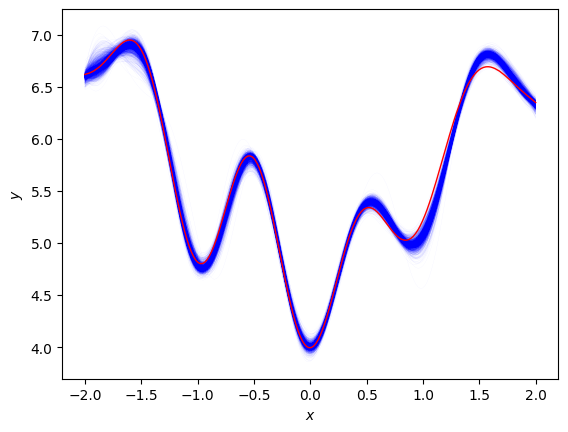

In [29]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
#ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_unmeasured, y1.mean(0), lw=.1, zorder=0, c='b', alpha=.1)
l, = ax.plot(X_unmeasured, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")

# Suggested Experiments to Try

As we discussed, the ground truth function is, well, ground truth - it is not available to the scientists. The noise defines how well we can measure it (noise in the measurement system). Note that E(noise) = 0, because otherwise we have systematic error that we cannot find experimentally. As an example, in microscopy experiment if out microscope is uncalibrated, we will not be able to learn it from many repeated experiments - we will need calibration sample (aka sample that we trust more then microscope).

From the perspective of the GP, the algorithm has access to prior data. Based on the prior data, it tries to reconstruct the function and its uncertainty.

The key parameters we need to consider in this process are prior on noise, kernel length, and kernel scale. Prior on noise means "how much we trust our measurements". Prior on kernel length means "how fast we think the function can/should change along x-axis". Prior on scale is relatively less important and determines vertical scale.

As an experiment, try:

1. Choose the noise to be 0.01 (small) and noise prior 1.0. Keep kernel length to be U(0.1, 2). In this case, your real noise is small, but your belief is that noise is large (aka you do not trust your measurements). What happens? See how the uncertainties evolve, and how well reconstructed function learns the ground truth behavior.

2. Now make the noise 1.0. Meaning that our experimental noise is large, and we know that it is large (rerun the notebook from the beginning). Looks like with this type of noise we are really not learning much! If you have time and inclination, run the code for 100 steps and see what changes.

3. Now make the noise to be 1.0 (large), but noise prior to be 0.01. Meaning that real noise in high, but we believe our measurements far more then we should. What happens in this case (go back to 10 steps).It is actually pretty remarcable - the algorithm will try to interpret each noise spike as real behavior, and try to adapt by making kernel length smaller. Again, consider making the experiment longer and see how it starts to discover true behavior.

4. Now make both noise and noise prior small - 0.01 and 0.01. Sometimes scientific discovery can be quick and easy!

5. Now let's experiment with the kernel. We use a uniform distirbution for kernel length - meaning that we can confine it to rigid boundaries. As a start, set the distribution U[2,10] and see what happens (keep noise and noise prior as 0.01 and 0.01)

6. Now make it U[5,10] and enjoy the show. Sometimes if your assumptions are (a) wrong and (b) rigid, the process will never converge! The GP algorithm will compensate for the inability to describe small wiggles by increasin the noise (so it stops believing the measurements).

I have not tried it, but it may be curious to set noise prior to be U[0.01, 0.02] - so noise is constarined as well.

7. Now play with the reverse limitation. Set the kernel length as U[0.01, 0.1]. What happens?

# Summary (add your own observations!)

1. Gaussian Process will always discover the ground truth if the priors allow for it.
2. However, the length of the experiment really depends on the priors
3. The best convergence is achieved when our ideas about correlations in parameter space and noise are close to reality
4. If the priors are chosen to be rigid and wrong, GP will fail

# Optional Exercise: Kernel Functions

1. **Radial basis function kernel**

gpax.kernels.RBFKernel(X, Z, params, noise=0, **kwargs)

Parameters:
- X (Array) – 2D vector with (number of points, number of features) dimension
- Z (Array) – 2D vector with (number of points, number of features) dimension
- params (Dict[str, Array]) – Dictionary with kernel hyperparameters ‘k_length’ and ‘k_scale’
- noise (int) – optional noise vector with dimension (n,)



2. **Matern52 kernel**

gpax.kernels.MaternKernel(X, Z, params, noise=0, **kwargs)

Parameters
- X (Array) – 2D vector with (number of points, number of features) dimension
- Z (Array) – 2D vector with (number of points, number of features) dimension
- params (Dict[str, Array]) – Dictionary with kernel hyperparameters ‘k_length’ and ‘k_scale’
- noise (int) – optional noise vector with dimension (n,)

3. **Periodic Kernel**

gpax.kernels.PeriodicKernel(X, Z, params, noise=0, **kwargs)[source]

Parameters:
- X (Array) – 2D vector with (number of points, number of features) dimension
- Z (Array) – 2D vector with (number of points, number of features) dimension
- params (Dict[str, Array]) – Dictionary with kernel hyperparameters ‘k_length’, ‘k_scale’, and ‘period’
- noise (int) – optional noise vector with dimension (n,)

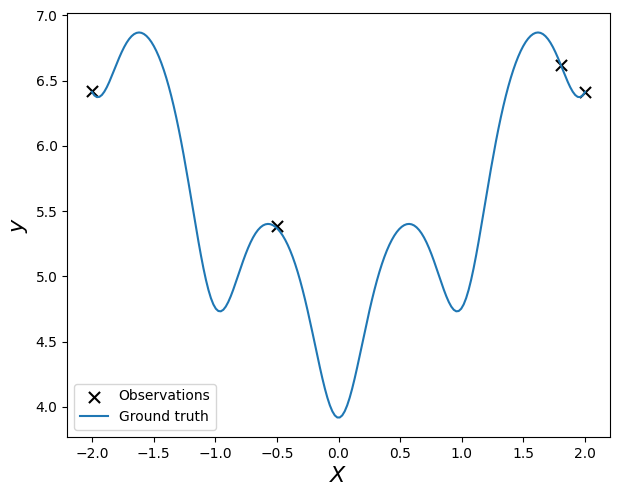

In [30]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(2,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

In [31]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.01))

def gp_kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.1, 2)) #0.1 2
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    period = numpyro.sample("period", numpyro.distributions.Uniform(0.1, 4.0))
    # the hyperparameters are returned as dictionary
    return {"k_length": length, "k_scale": scale, "period": period}

In [32]:
def step(X_measured, y_measured, X_unmeasured):
    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()
    # Initialize GP model
    gp_model = gpax.ExactGP(1, kernel='Periodic', kernel_prior=gp_kernel_prior, noise_prior=noise_prior)
    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(rng_key1, X_measured, y_measured)
    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True, n= 10)

    # Compute acquisition function
    # Upper confidence bound
    # obj = gpax.acquisition.UCB(
    #     rng_key2, gp_model, X_unmeasured, beta=0.01, #4
    #     maximize=False, noiseless=True)

    # pure uncertainty-based
    obj = gpax.acquisition.UE(
        rng_key2, gp_model, X_unmeasured,
        noiseless=True)


    return obj, (y_pred, y_sampled)


Step 1/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 756.36it/s, 7 steps of size 2.83e-01. acc. prob=0.67] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.60      0.30      1.67      1.18      2.00    500.10      1.01
   k_scale      8.39      4.75      7.04      2.95     14.58    729.36      1.00
     noise      0.01      0.01      0.01      0.00      0.02    291.15      1.01
    period      1.94      0.10      1.98      1.78      2.07    309.88      1.00



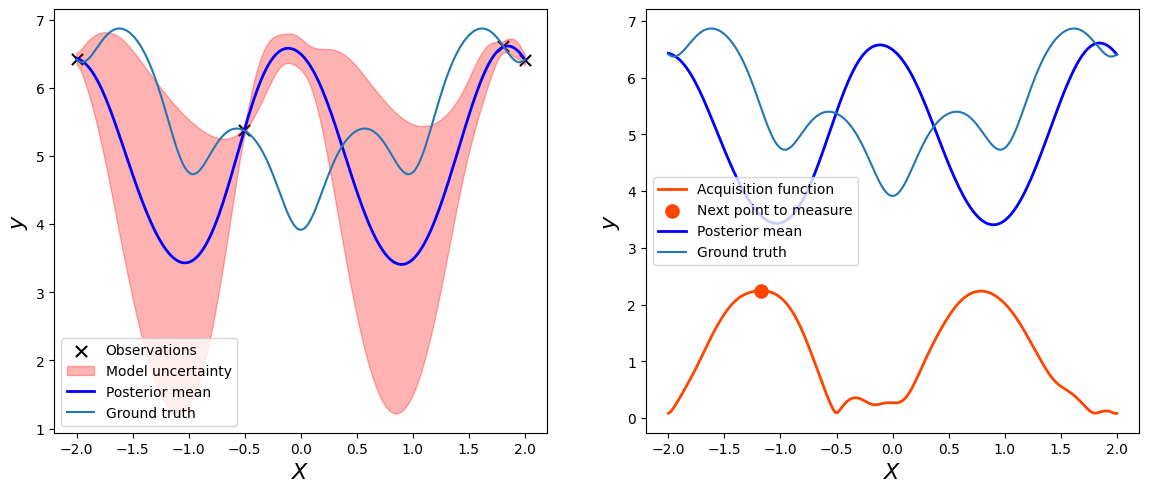


Step 2/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 631.75it/s, 7 steps of size 4.72e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.36      0.29      1.37      0.94      1.89   1336.18      1.00
   k_scale     11.65      6.05     10.21      4.48     19.41   1372.11      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1279.71      1.00
    period      2.70      0.05      2.70      2.63      2.79   1036.52      1.00



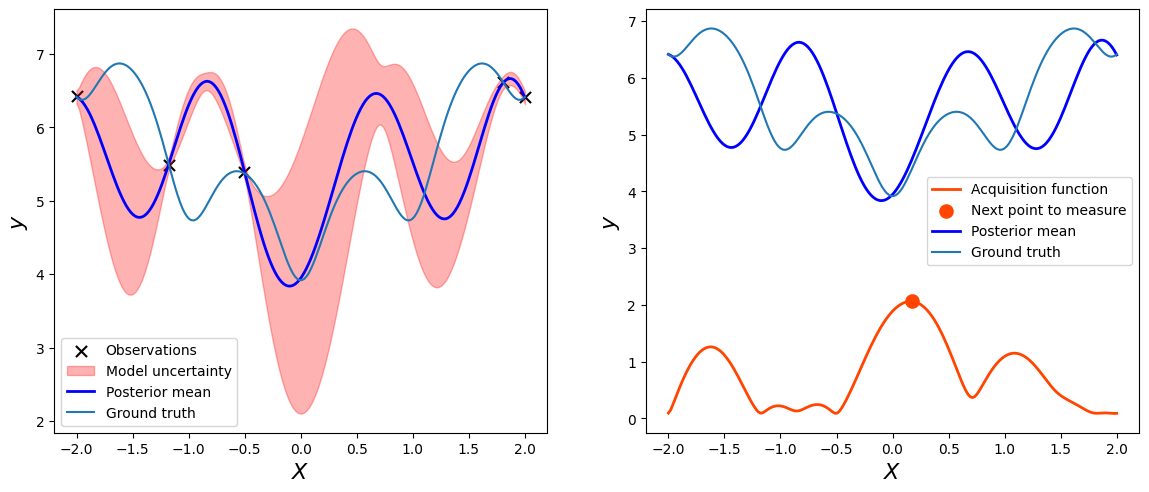


Step 3/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 690.20it/s, 7 steps of size 3.99e-01. acc. prob=0.60]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.68      0.24      1.70      1.33      2.00    442.52      1.01
   k_scale      7.70      4.16      6.68      2.46     12.48    396.19      1.00
     noise      0.01      0.01      0.01      0.00      0.02    420.29      1.00
    period      3.79      0.16      3.81      3.58      4.00    152.49      1.00



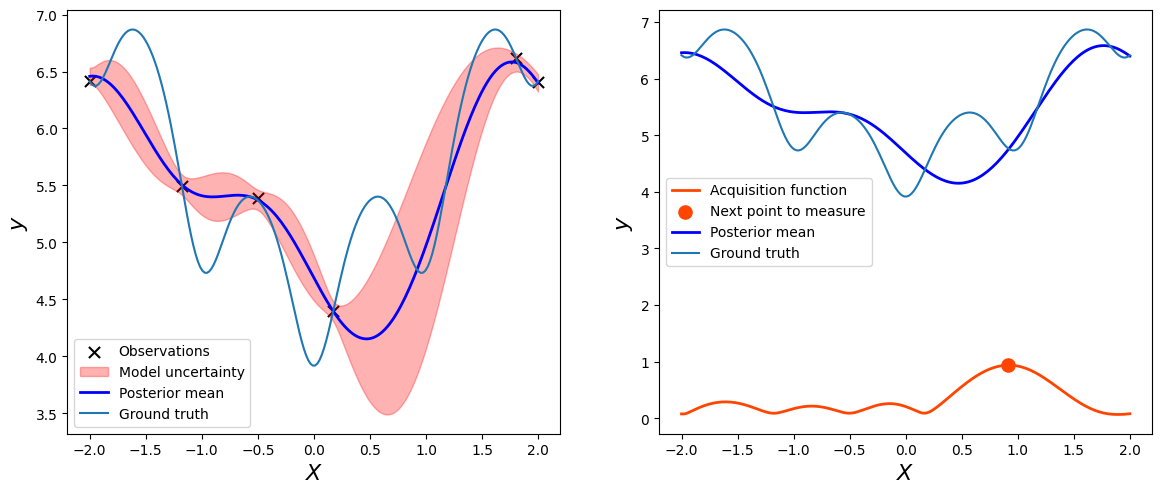


Step 4/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 509.78it/s, 31 steps of size 3.20e-01. acc. prob=0.66]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.72      0.21      1.74      1.42      2.00    518.39      1.01
   k_scale      7.65      3.85      6.77      2.67     12.60    447.68      1.00
     noise      0.01      0.01      0.01      0.00      0.02    313.26      1.00
    period      3.79      0.17      3.84      3.55      4.00    214.94      1.00



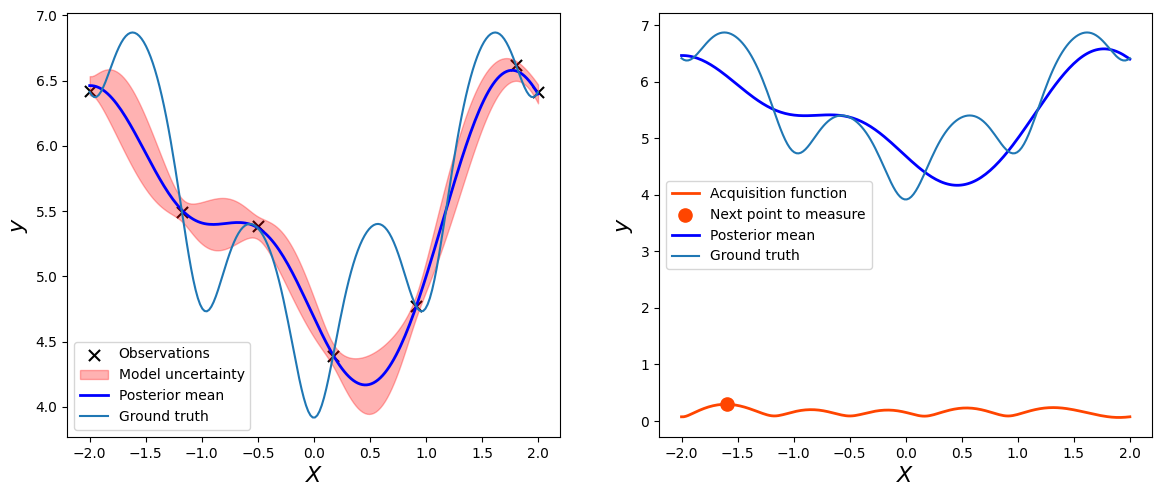


Step 5/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 641.06it/s, 7 steps of size 1.17e-01. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.66      0.14      0.67      0.43      0.90    670.48      1.00
   k_scale     17.44      8.24     15.79      6.59     26.74    480.86      1.00
     noise      0.01      0.01      0.01      0.00      0.02    530.79      1.00
    period      2.25      0.01      2.25      2.22      2.27   1799.53      1.00



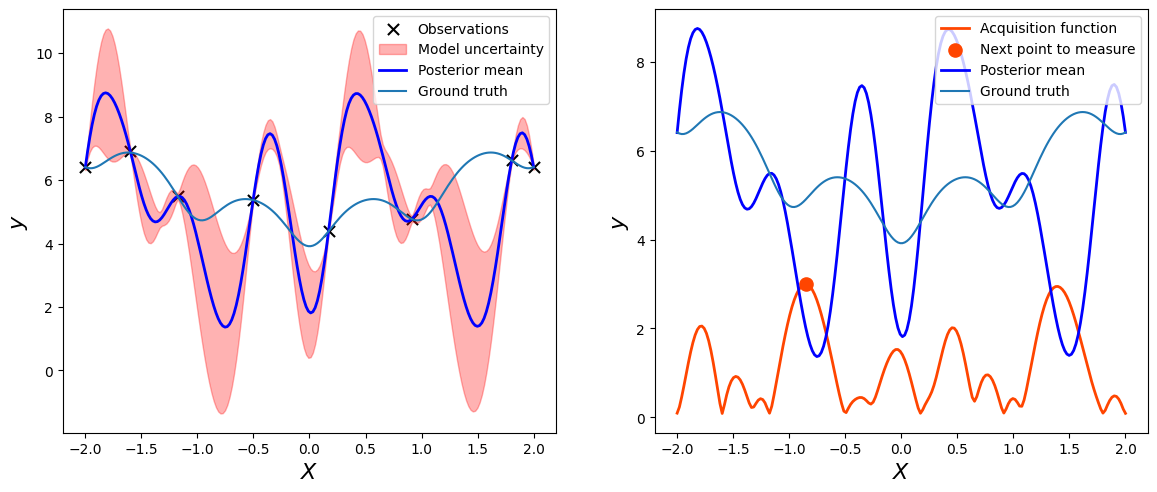


Step 6/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 561.23it/s, 7 steps of size 3.96e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.13      0.68      0.46      0.89   1002.43      1.00
   k_scale     17.93      7.98     16.15      6.98     28.13    857.37      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1227.50      1.00
    period      2.24      0.01      2.24      2.22      2.27    925.91      1.00



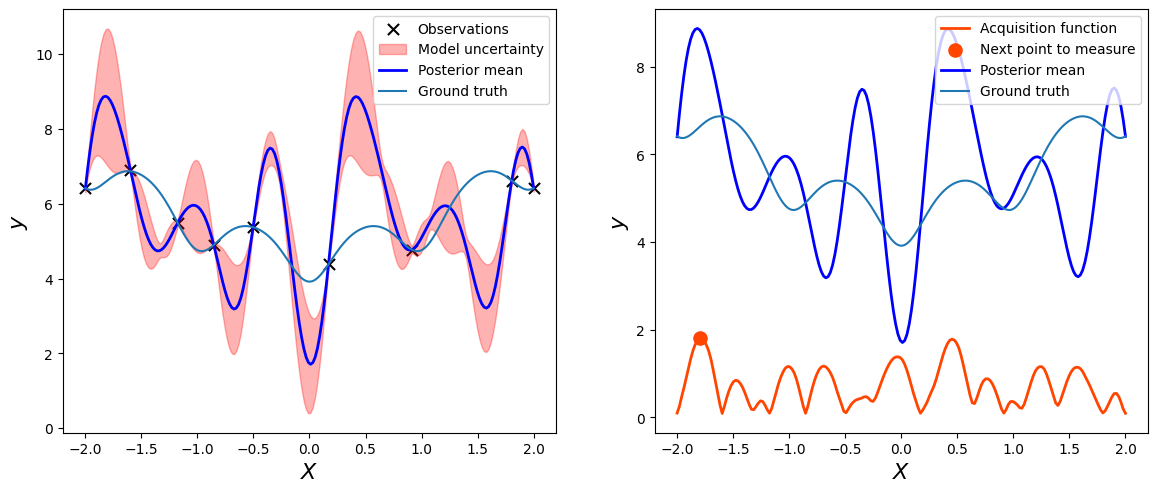


Step 7/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 619.94it/s, 7 steps of size 4.60e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.57      0.09      0.57      0.41      0.71   1047.87      1.00
   k_scale     16.90      7.31     15.26      7.50     26.47   1334.31      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1050.29      1.00
    period      2.25      0.01      2.25      2.23      2.27   1396.90      1.00



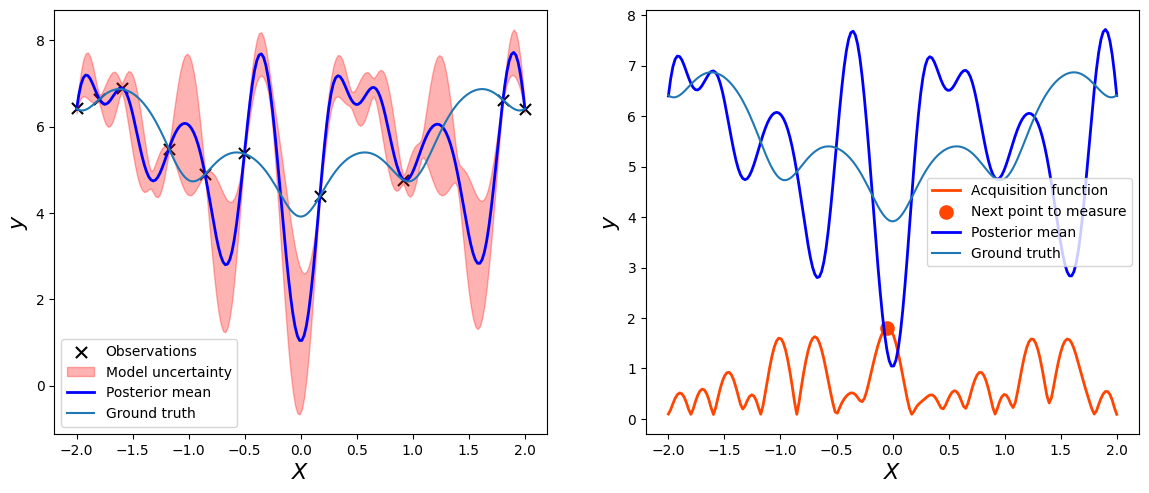


Step 8/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 574.74it/s, 7 steps of size 4.59e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.51      0.08      0.52      0.39      0.63    680.96      1.00
   k_scale     16.27      6.73     14.73      7.40     25.07   1450.81      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1349.18      1.00
    period      2.25      0.02      2.25      2.23      2.27   1175.24      1.00



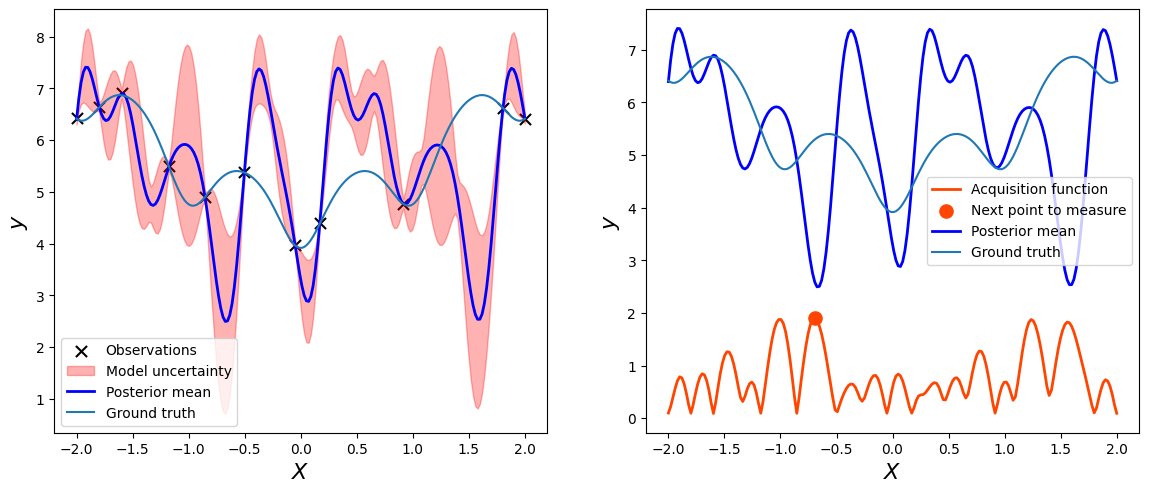


Step 9/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 481.08it/s, 7 steps of size 4.49e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.48      0.06      0.48      0.38      0.58   1348.35      1.00
   k_scale     16.30      6.56     14.76      7.23     24.70    948.12      1.00
     noise      0.01      0.01      0.01      0.00      0.02    892.50      1.00
    period      2.24      0.01      2.24      2.22      2.27   1370.47      1.00



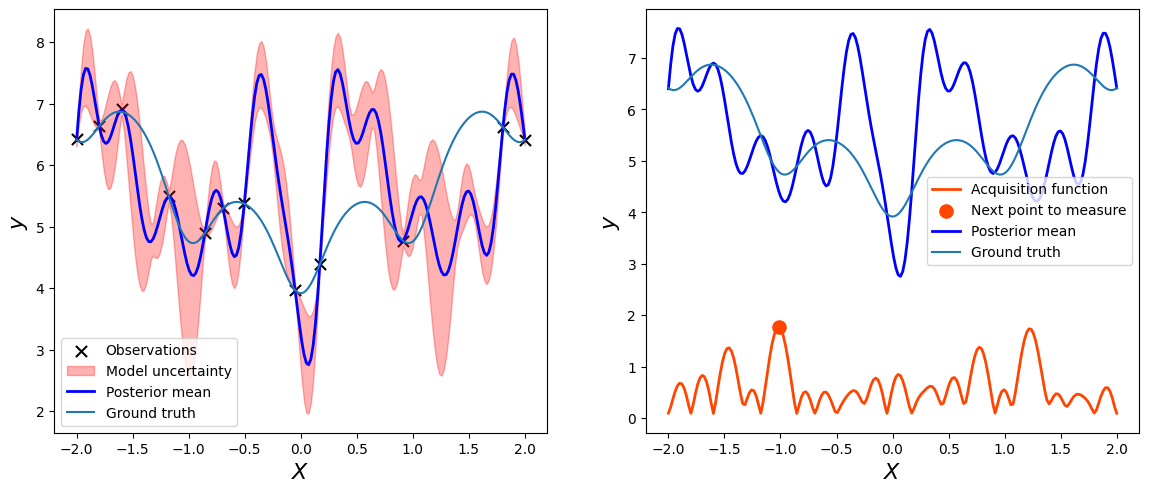


Step 10/10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 596.89it/s, 7 steps of size 5.48e-01. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.50      0.06      0.50      0.41      0.59   1065.77      1.00
   k_scale     15.27      5.80     14.07      7.71     22.97   1348.74      1.00
     noise      0.01      0.01      0.01      0.00      0.02   1093.94      1.00
    period      2.24      0.01      2.24      2.22      2.26   1096.70      1.00



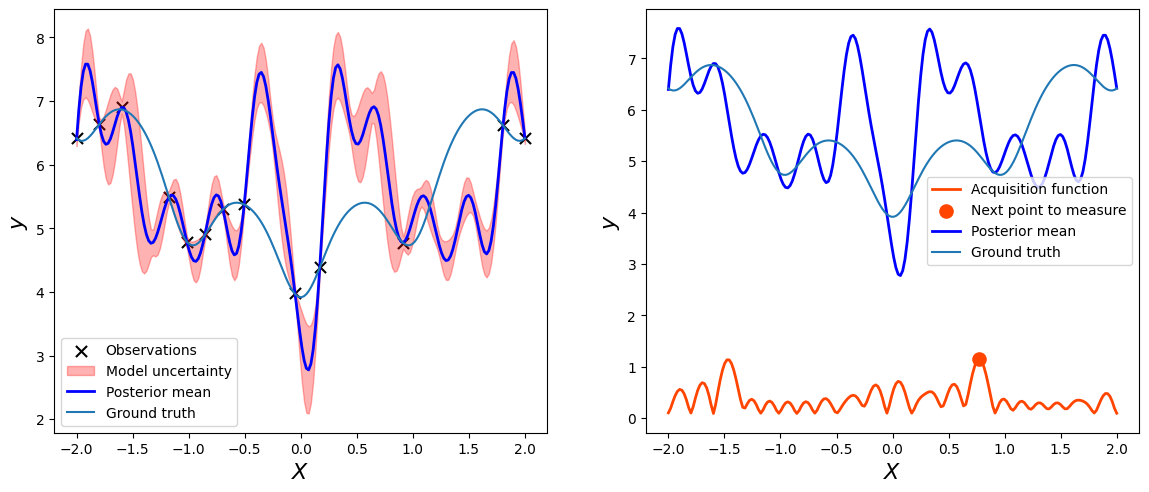

In [33]:
num_steps = 10

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured[idx:idx+1]
    # Measure the point
    next_point_value = measure(next_point)
    # Update measured data
    X = np.append(X, X_unmeasured[idx:idx+1])
    y = np.append(y, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
        ax.plot(X_unmeasured, ground_truth, label='Ground truth')
        #ax.set_ylim(3.0, 8)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()